<a href="https://colab.research.google.com/github/Hanh6931/Hanh6931/blob/main/StateUnion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install datasets -q

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from collections import Counter

from datetime import datetime, timedelta

import nltk
from nltk.draw.dispersion import dispersion_plot

In [15]:
# Load the dataset
dataset = load_dataset("jsulz/state-of-the-union-addresses")

# Extract the necessary columns
dates = [item["date"] for item in dataset["train"]]
potus=[item["potus"] for item in dataset["train"]]
texts = [item["lemmatized"] for item in dataset["train"]]

# Combine dates, potus texts, then sort by dates
sorted_data = sorted(zip(dates, potus, texts), key=lambda x: x[0])
sorted_dates, sorted_potus,sorted_texts = zip(*sorted_data)




In [16]:
sorted_dates[0:8]

(Timestamp('1790-01-08 00:00:00'),
 Timestamp('1790-12-08 00:00:00'),
 Timestamp('1791-10-25 00:00:00'),
 Timestamp('1792-11-06 00:00:00'),
 Timestamp('1793-12-03 00:00:00'),
 Timestamp('1794-11-19 00:00:00'),
 Timestamp('1795-12-08 00:00:00'),
 Timestamp('1796-12-07 00:00:00'))

In [17]:
# prompt: FIrst partition the data into 5-year blocks. The initial date for grouping should be
# start_date = pd.Timestamp('1790-01-08')

import pandas as pd

start_date = pd.Timestamp('1790-01-08')

# Convert dates to datetime objects
dates_dt = pd.to_datetime(sorted_dates)

# Calculate the difference in years from the start date
# The original line caused the error because 'TimedeltaIndex' doesn't have a 'dt' attribute.
# Instead, we use the '.days' attribute directly on the 'TimedeltaIndex' object and then divide by 365.25.
years_diff = (dates_dt - start_date).days / 365.25

# Partition the data into 5-year blocks
five_year_blocks = (years_diff // 5).astype(int)

# Group data by the 5-year blocks
partitioned_data = {}
for i, block in enumerate(five_year_blocks):
    if block not in partitioned_data:
        partitioned_data[block] = []
    partitioned_data[block].append({
        'date': dates_dt[i],
        'potus': sorted_potus[i],
        'text': sorted_texts[i]
    })

In [18]:
# prompt: Restructure blocks into dictionaries, where each dictionary contains a year (extracted from the first entry’s date) and a merged list of text consisting of the lemmatized words from all entries in the block.

restructured_data = []
for block_num, entries in partitioned_data.items():
  year = entries[0]['date'].year  # Extract year from the first entry's date
  merged_text = []
  for entry in entries:
    merged_text.extend(entry['text'])
  restructured_data.append({'year': year, 'text': merged_text})


In [19]:
# prompt: Find the length of the longest 'text' field, then pad this list of  lemmatized  words for all the other processed blocks with "OOV" tokens. These are blanks, introduced to give uniformity of the timeline (Years).

max_len = 0
for item in restructured_data:
    max_len = max(max_len, len(item['text']))

padded_data = []
for item in restructured_data:
    padding_length = max_len - len(item['text'])
    padded_text = item['text'] + ['OOV'] * padding_length
    padded_data.append({'year': item['year'], 'text': padded_text})


<Figure size 1200x600 with 0 Axes>

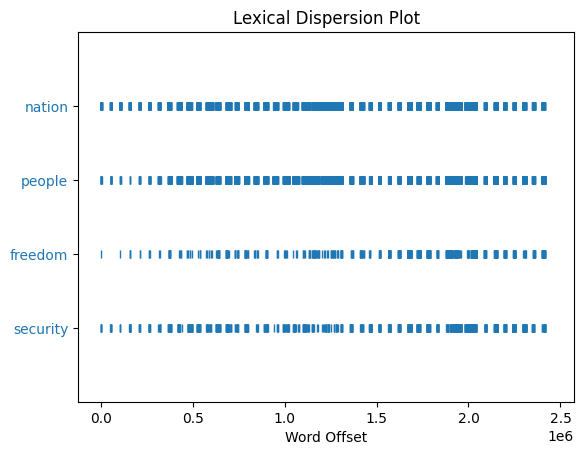

In [20]:
# prompt: Produce the lexical dispersion plot.

import matplotlib.pyplot as plt
# Convert the list of dictionaries to a list of texts
texts = [item['text'] for item in padded_data]

# Define the target words for the dispersion plot
target_words = ['nation', 'people', 'freedom', 'security']

# Create the dispersion plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Concatenate the list of lists into a single flat list.
flattened_texts = [token for sublist in texts for token in sublist]

# Now call dispersion_plot with the flattened list
dispersion_plot(flattened_texts, target_words, ignore_case=True)
plt.show()